In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [6]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, TimeDistributed, LSTM, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

In [7]:
## Loading the model and working

In [8]:
#load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('mini_cnn_model.keras')


In [37]:
from keras.preprocessing import image

In [38]:
img=image.load_img('C:/Users/shrey/MajorProject/dataset/positive/00045.jpg')

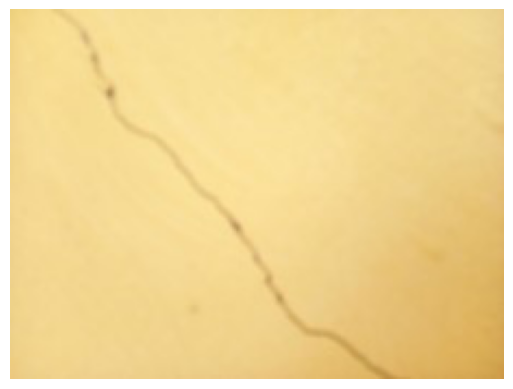

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
It is a crack


In [39]:
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()  # Show the image
X = image.img_to_array(img)
X = np.expand_dims(X, axis=0)
X = X / 255.0  # Normalize the image
# Assuming 'model' is your pre-trained model
val = loaded_model.predict(X)

# If the output is a probability, use an appropriate threshold
if val[0][0] > 0.5:  # Adjust threshold as needed
    print("It is a crack")
else:
    print("There is no crack")

In [40]:
# Run depth estimation
msg, crack_depth_mm = estimate_crack_depth('C:/Users/shrey/MajorProject/dataset/positive/00045.jpg')

# Print the raw message from estimation
print(msg)

# If we got a valid depth, classify seriousness
if crack_depth_mm is not None:
    seriousness = classify_seriousness(crack_depth_mm)
    print(f"Depth {crack_depth_mm:.2f} mm → {seriousness}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
No crack detected


In [41]:
msg, depth = estimate_crack_depth('C:/Users/shrey/MajorProject/Proj/Fortest/bridgecrack.png')
print(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Crack detected. Estimated depth: 4.56 mm


In [14]:
###For Videos

In [1]:
# import os
# import cv2
# import numpy as np
# from keras.models import load_model

# # Load your trained model
# model = load_model('mini_cnn_model.keras')

# # Define label
# label_text = "Crack Detected"

# # Load video
# video_path = 'C:/Users/shrey/MajorProject/Proj/Videos/Viideo2_withcrackand noteog.mp4'
# cap = cv2.VideoCapture(video_path)

# if not cap.isOpened():
#     print("Error: Could not open video.")
#     exit()

# # Get video properties
# frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fps = cap.get(cv2.CAP_PROP_FPS)

# # Define output file path (full path with filename)
# output_dir = 'C:/Users/shrey/MajorProject/Proj/outputs'
# os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists
# output_path = os.path.join(output_dir, 'annotated_output.mp4')

# # Initialize VideoWriter
# out = cv2.VideoWriter(output_path,
#                       cv2.VideoWriter_fourcc(*'mp4v'),
#                       fps,
#                       (frame_width, frame_height))

# # Loop over frames
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Preprocess frame for your model
#     resized_frame = cv2.resize(frame, (227, 170))   # Adjust as per your model input
#     normalized_frame = resized_frame / 255.0
#     input_frame = np.expand_dims(normalized_frame, axis=0)

#     # Predict
#     prediction = model.predict(input_frame, verbose=0)[0][0]  # Sigmoid output assumed

#     # If crack detected
#     if prediction > 0.5:
#         # Overlay text
#         cv2.putText(frame, label_text, (30, 50),
#                     cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)

#     # Write annotated frame
#     out.write(frame)

# # Release resources
# cap.release()
# out.release()
# #cv2.destroyAllWindows()

# # Confirm output
# print(f"Annotated video saved to: {os.path.abspath(output_path)}")


Annotated video saved to: C:\Users\shrey\MajorProject\Proj\outputs\annotated_output.mp4


In [52]:
import cv2
import numpy as np
import pandas as pd
from keras.models import load_model

# Load trained model
model = load_model("mini_cnn_model.keras")

# Calibration constants (adjust after calibration)
PIXEL_TO_MM = 0.05   # 1 pixel = 0.05 mm
DEPTH_FACTOR = 0.8   # linear relation width→depth

# Crack seriousness thresholds
def classify_seriousness(depth):
    if depth < 1:
        return "Minor"
    elif depth < 2:
        return "Moderate"
    else:
        return "Severe"

def estimate_crack_depth_from_frame(frame):
    resized = cv2.resize(frame, (227,170))
    input_img = resized / 255.0
    input_img = np.expand_dims(input_img, axis=0)

    # Predict crack/no crack
    pred = model.predict(input_img, verbose=0)[0][0]
    if pred < 0.5:
        return None  # No crack

    # ---- Crack detected → measure width ----
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    crack_contour = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(crack_contour)

    # Create mask for the crack region
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [crack_contour], -1, 255, thickness=cv2.FILLED)

    # Measure crack width across rows inside bounding box
    widths = []
    for row in range(y, y+h):
        line = mask[row, x:x+w]
        points = np.where(line > 0)[0]
        if len(points) > 1:
            widths.append(points[-1] - points[0])  # distance between edges

    if not widths:
        return None

    avg_width_px = np.mean(widths)  # average crack width in pixels
    crack_width_mm = avg_width_px * PIXEL_TO_MM
    crack_depth_mm = crack_width_mm * DEPTH_FACTOR

    seriousness = classify_seriousness(crack_depth_mm)

    return crack_depth_mm, seriousness


# ---- Process video and save report ----
def process_video(video_path, output_path="output_with_depth.mp4", report_path="crack_report.csv"):
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    report_data = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        result = estimate_crack_depth_from_frame(frame)

        if result is not None:
            depth, seriousness = result
            text = f"Depth: {depth:.2f} mm | {seriousness}"
            cv2.putText(frame, text,
                        (50, 50), cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0,0,255), 2)

            report_data.append({
                "Frame": frame_count,
                "Depth (mm)": round(depth, 2),
                "Seriousness": seriousness
            })

        out.write(frame)

    cap.release()
    out.release()

    # Save report
    if report_data:
        df = pd.DataFrame(report_data)

        # --- Summary ---
        max_depth = df["Depth (mm)"].max()
        avg_depth = df["Depth (mm)"].mean()
        most_serious = df["Seriousness"].apply(lambda x: ["Minor","Moderate","Severe"].index(x)).max()
        most_serious_label = ["Minor","Moderate","Severe"][most_serious]

        summary = {
            "Max Depth (mm)": round(max_depth, 2),
            "Average Depth (mm)": round(avg_depth, 2),
            "Most Serious Crack": most_serious_label
        }

        # Save per-frame + summary
        with open(report_path, "w") as f:
            df.to_csv(f, index=False)
            f.write("\n--- Summary ---\n")
            for key, val in summary.items():
                f.write(f"{key}: {val}\n")

        print(f"✅ Processing complete! Video saved at: {output_path}")
        print(f"📊 Report saved at: {report_path}")
        print(df.head())  # show first few rows
        print("\n--- Summary ---")
        for key, val in summary.items():
            print(f"\n{key}: {val}")

    else:
        print("⚠️ No cracks detected in the video.")


In [53]:
process_video("C:/Users/shrey/MajorProject/Proj/Videos/iclick.mp4")


✅ Processing complete! Video saved at: output_with_depth.mp4
📊 Report saved at: crack_report.csv
   Frame  Depth (mm)                      Seriousness
0      1        2.83                   Severe (alert)
1      2        1.13  Moderate might need monitoring.
2      3        0.78                            Minor
3      4        2.62                   Severe (alert)
4      5        1.85  Moderate might need monitoring.

--- Summary ---

Max Depth (mm): 4.35

Average Depth (mm): 1.19

Most Serious Crack: Severe (alert)


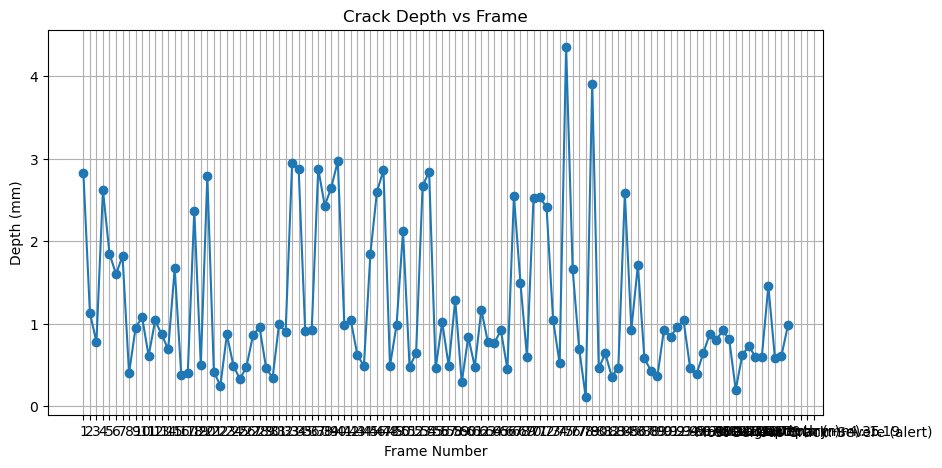

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("crack_report.csv")

plt.figure(figsize=(10,5))
plt.plot(df["Frame"], df["Depth (mm)"], marker='o')
plt.title("Crack Depth vs Frame")
plt.xlabel("Frame Number")
plt.ylabel("Depth (mm)")
plt.grid(True)
plt.show()
